In [22]:
%load_ext autoreload
%autoreload 2

import jax
from brax import envs
from Rodent_Env_Brax import RodentMultiClipTracking, RodentTracking
import pickle
from preprocessing.mjx_preprocess import process_clip_to_train
import pickle
import os
from matplotlib import pyplot as plt
import numpy as np

try:
    n_devices = jax.device_count(backend="gpu")
    os.environ["XLA_FLAGS"] = (
        "--xla_gpu_enable_triton_softmax_fusion=true " "--xla_gpu_triton_gemm_any=True "
    )
    print(f"Using {n_devices} GPUs")
except:
    n_devices = 1
    print("Not using GPUs")

config = {
    "env_name": "multi clip",
    "algo_name": "ppo",
    "task_name": "run",
    "num_envs": 128 ,
    "num_timesteps": 5_000_000_000,
    "eval_every": 50_000_000,
    "episode_length": 200,
    "batch_size": 128 ,
    "num_minibatches": 4,
    "num_updates_per_batch": 8,
    "learning_rate": 7e-5,
    "clipping_epsilon": 0.2,
    "torque_actuators": False,
    "physics_steps_per_control_step": 5,
    "too_far_dist": 0.01,
    "bad_pose_dist": 20,
    "bad_quat_dist": 1,
    "ctrl_cost_weight": 0.02,
    "pos_reward_weight": 1.0,
    "quat_reward_weight": 1.0,
    "joint_reward_weight": 1.0,
    "angvel_reward_weight": 0.0,
    "bodypos_reward_weight": 0.0,
    "endeff_reward_weight": 1.0,
    "healthy_z_range": (0.0325, 0.5),
    "run_platform": "Harvard",
    "solver": "cg",
    "iterations": 4,
    "ls_iterations": 4,
}

envs.register_environment("single clip", RodentTracking)
envs.register_environment("multi clip", RodentMultiClipTracking)

clip_id = -1
with open("./clips/all_snips.p", "rb") as file:
    # Use pickle.load() to load the data from the file
    reference_clip = pickle.load(file)
    
# reference_path = f"clips/84.p"

# with open(reference_path, "rb") as file:
#     # Use pickle.load() to load the data from the file
#     reference_clip = pickle.load(file)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Not using GPUs


In [23]:
# instantiate the environment
env = envs.get_environment(
    config["env_name"],
    reference_clip=reference_clip,
    torque_actuators=config["torque_actuators"],
    solver=config["solver"],
    iterations=config["iterations"],
    ls_iterations=config["ls_iterations"],
    too_far_dist=config["too_far_dist"],
    bad_pose_dist=config["bad_pose_dist"],
    bad_quat_dist=config["bad_quat_dist"],
    ctrl_cost_weight=config["ctrl_cost_weight"],
    pos_reward_weight=config["pos_reward_weight"],
    quat_reward_weight=config["quat_reward_weight"],
    joint_reward_weight=config["joint_reward_weight"],
    angvel_reward_weight=config["angvel_reward_weight"],
    bodypos_reward_weight=config["bodypos_reward_weight"],
    endeff_reward_weight=config["endeff_reward_weight"],
    healthy_z_range=config["healthy_z_range"],
    physics_steps_per_control_step=config["physics_steps_per_control_step"],
)

self._steps_for_cur_frame: 2.0


In [24]:
import custom_wrappers
# Wrap the env in the brax autoreset and episode wrappers
rollout_env =  custom_wrappers.RenderRolloutWrapperTracking(env)
# rollout_env = custom_wrappers.AutoResetWrapperTracking(
#     custom_wrappers.RenderRolloutWrapperTracking(env)
# )
# define the jit reset/step functions
jit_reset = jax.jit(rollout_env.reset)
jit_step = jax.jit(rollout_env.step)
key = jax.random.PRNGKey(0)


In [25]:
_, key = jax.random.split(key)
state = jit_reset(key)

In [26]:
state.info["reference_obs_size"]

Array(470, dtype=int32, weak_type=True)

In [21]:
rollout_env._get_reference_clip(state.info)

ReferenceClip(position=Array([[ 5.41238934e-02,  4.67376888e-01,  5.94116822e-02],
       [ 5.81502058e-02,  4.69710618e-01,  6.22830465e-02],
       [ 5.87985888e-02,  4.71593648e-01,  6.43148497e-02],
       [ 5.91593273e-02,  4.72413629e-01,  6.50602803e-02],
       [ 5.87293766e-02,  4.72802728e-01,  6.52226806e-02],
       [ 5.78073487e-02,  4.72730547e-01,  6.47324622e-02],
       [ 5.66448346e-02,  4.72547382e-01,  6.40193522e-02],
       [ 5.55244051e-02,  4.72015738e-01,  6.33002296e-02],
       [ 5.43175787e-02,  4.71392751e-01,  6.24222755e-02],
       [ 5.25386073e-02,  4.70301151e-01,  6.10659793e-02],
       [ 5.07670566e-02,  4.69330907e-01,  5.99728972e-02],
       [ 4.92088050e-02,  4.68387365e-01,  5.88246547e-02],
       [ 4.75932248e-02,  4.67358142e-01,  5.74649200e-02],
       [ 4.64246124e-02,  4.66612786e-01,  5.68301417e-02],
       [ 4.56404500e-02,  4.66161579e-01,  5.59326522e-02],
       [ 4.47611436e-02,  4.65796322e-01,  5.55033423e-02],
       [ 4.444649

In [8]:
from jax import numpy as jp
rollout = []
spd = []
for _ in range(400):
    _, key = jax.random.split(key)
    # state = jit_step(state, jax.random.normal(key, (env.sys.nu,)))
    state = jit_step(state, jp.zeros((env.sys.nu,)))

    # print(state.info['cur_frame'], state.done)
    # spd.append(state.info["summed_pos_distance"])
    rollout.append(state)

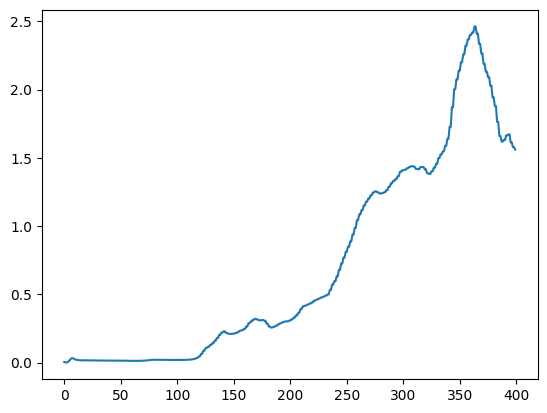

In [9]:
plt.plot([state.info["quat_distance"] for state in rollout])

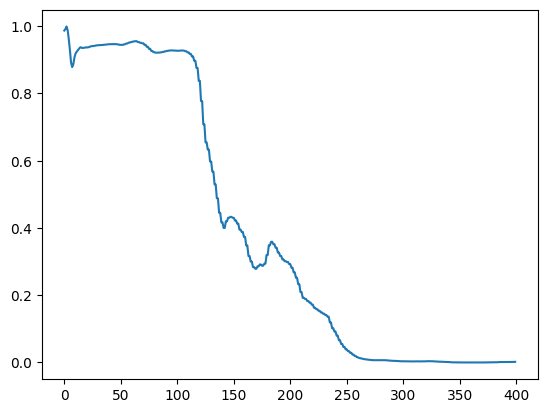

In [10]:
plt.plot([state.metrics["quat_reward"] for state in rollout])

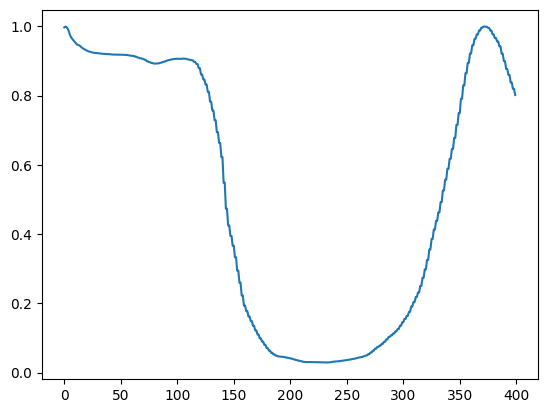

In [11]:
plt.plot([state.metrics["endeff_reward"] for state in rollout]) 

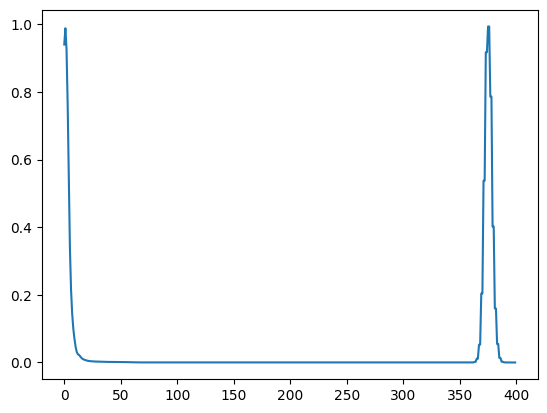

In [7]:
plt.plot([state.metrics["bodypos_reward"] for state in rollout])

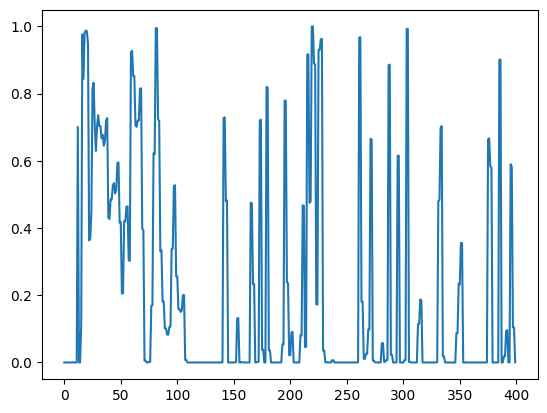

In [9]:
plt.plot([state.metrics["angvel_reward"] for state in rollout])

In [7]:
joint_dists = [state.info["joint_distance"] for state in rollout]

In [10]:
def f(d):
    return rollout_env._joint_reward_weight * jp.exp(-0.1 * jp.sum(d) ** 2)
    
joint_rewards = [f(d) for d in joint_dists]

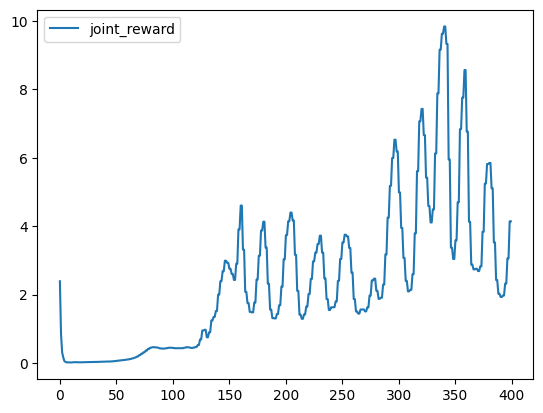

In [11]:
plt.plot(joint_rewards, label="joint_reward")
plt.legend()
plt.show()

In [22]:
for i, (r, d) in enumerate(zip([state.metrics["pos_reward"] for state in rollout], [state.info["summed_pos_distance"] for state in rollout])):
    if d > 0.001:
        print(i, r, d)

45 0.17518589 0.0010342624
46 0.1740039 0.0010356187
47 0.14245069 0.0011354182
48 0.14140674 0.0011369821
49 0.118520625 0.0012380662
50 0.117734715 0.001239472
51 0.09966092 0.0013342883
52 0.099095985 0.0013355241
53 0.08247027 0.0014529745
54 0.08210924 0.0014538671
55 0.06684441 0.0015810501
56 0.066623256 0.0015816535
57 0.051114492 0.001760601
58 0.050974756 0.0017610962
59 0.04046556 0.0019096059
60 0.0403713 0.0019100383
61 0.032484695 0.00204826
62 0.032409083 0.0020487087
63 0.027822118 0.0021448364
64 0.027746562 0.0021454461
65 0.026591621 0.0021704123
66 0.02650785 0.0021712102
67 0.026928678 0.0021506774
68 0.026837625 0.0021516122
69 0.028542358 0.0021057418
70 0.028436929 0.0021067457
71 0.03138823 0.0020394642
72 0.031258106 0.0020407098
73 0.033984467 0.0019912634
74 0.03384511 0.0019925314
75 0.037327148 0.0019292871
76 0.037177794 0.0019305522
77 0.03963769 0.0018837979
78 0.039484624 0.0018850127
79 0.04221716 0.0018308745
80 0.04205576 0.0018321584
81 0.044398412

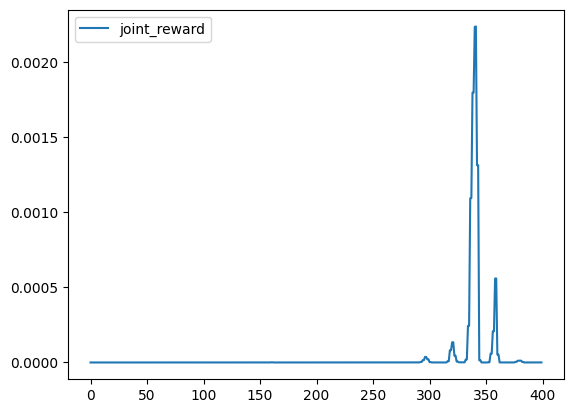

In [9]:

plt.plot([state.info["joint_distance"] for state in rollout], label="joint_reward")
# plt.plot([state.info["summed_pos_distance"] for state in rollout], label="summed_pos_distance")
# plt.yscale('log')
plt.legend()
plt.show()

In [34]:
np.array([state.done for state in rollout]).shape

(400,)

In [17]:
rollout[0].info["cur_frame"]

Array(0, dtype=int32, weak_type=True)

In [19]:
qposes_rollout = np.array([state.pipeline_state.qpos for state in rollout])
def f(x):
    if len(x.shape) != 1:
        return jax.lax.dynamic_slice_in_dim(
            x,
            0,
            250,
        )
    return jp.array([])

ref_traj = jax.tree_util.tree_map(f, reference_clip)
qposes_ref = np.repeat(
    np.hstack([ref_traj.position, ref_traj.quaternion, ref_traj.joints]),
    env._steps_for_cur_frame,
    axis=0
)
done_array = np.array([state.done for state in rollout])
reset_indices = np.where(done_array == 1.0)[0]
if reset_indices.shape[0] == 0:
    aligned_traj = qposes_ref
else:
    aligned_traj = np.zeros_like(qposes_rollout)
    # Set the first segment
    aligned_traj[: reset_indices[0] + 1] = qposes_ref[: reset_indices[0] + 1]

    # Iterate through reset points
    for i in range(len(reset_indices) - 1):
        start = reset_indices[i] + 1
        end = reset_indices[i + 1] + 1
        length = end - start
        aligned_traj[start:end] = qposes_ref[:length]

    # Set the last segment
    if reset_indices[-1] < len(done_array) - 1:
        start = reset_indices[-1] + 1
        length = len(done_array) - start
        aligned_traj[start:] = qposes_ref[:length]

(500, 74)

/var/folders/f1/rpl_f5_j46q42cptb030mpnr0000gn/T/ipykernel_50894/1694198976.py:33: UserWarning: frames=<zip object at 0x1589e80c0> which we can infer the length of, did not pass an explicit *save_count* and passed cache_frame_data=True.  To avoid a possibly unbounded cache, frame data caching has been disabled. To suppress this warning either pass `cache_frame_data=False` or `save_count=MAX_FRAMES`.
  ani = animation.FuncAnimation(fig, update, frames=zip(rollout, env._track_pos), interval=50, blit=True)


AssertionError: 

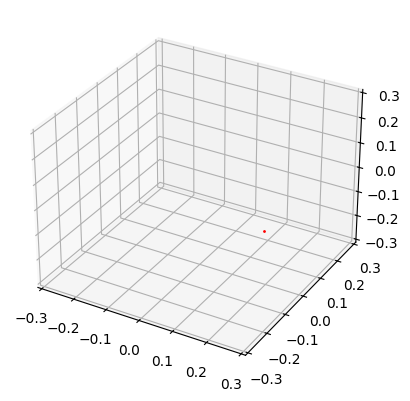

In [78]:
# Thanks Claude for this code
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation as animation

# Set up the figure and 3D axis
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Set the axis limits
ax.set_xlim([-0.3, 0.3])
ax.set_ylim([-0.3, 0.3])
ax.set_zlim([-0.3, 0.3])

# Initialize the point
ref, = ax.plot([], [], [], 'ro', markersize=1)
rol, = ax.plot([], [], [], 'bo', markersize=1)

# Animation update function
def update(carry):
    state, track_pos = carry
    ref.set_data([track_pos[0]], [track_pos[1]])
    ref.set_3d_properties([track_pos[2]])  
    
    revert = np.linalg.inv(state.pipeline_state.xmat[0]) @ state.obs[-7:][:3]
    assert np.allclose(track_pos - state.pipeline_state.qpos[:3], revert, atol=1e-6)
    rol.set_data([track_pos[0] + state.obs[-7:][0]], [track_pos[1] + state.obs[-7:][1]])
    rol.set_3d_properties([track_pos[2] + state.obs[-7:][2]])
    return ref, rol

# Create the animation
ani = animation.FuncAnimation(fig, update, frames=zip(rollout, env._track_pos), interval=50, blit=True)

# Save the animation as a GIF
ani.save('rat_position_tracking.gif', writer='pillow', fps=100)

plt.close(fig)

In [80]:
revert = np.linalg.inv(state.pipeline_state.xmat[0]) @ state.obs[-35:][:3]
assert np.allclose(env._track_pos[state.info['cur_frame']] - state.pipeline_state.qpos[:3], revert, atol=1e-8)

AssertionError: 

In [44]:
state.pipeline_state.contact.dist

Array([ 0.02668312,  0.00963982,  0.00365678,  0.07354705,  0.04750727,
        0.04865877,  0.03326368,  0.0376247 ,  0.01900179,  0.01720116,
        0.00490876,  0.01786475,  0.00469432,  0.01842165,  0.00612925,
        0.07880929,  0.05621161,  0.05623355,  0.05488762,  0.04300088,
        0.0606983 ,  0.02790296,  0.04077419,  0.02813101,  0.0419216 ,
        0.03007138,  0.0429426 ,  0.07854627,  0.07861307,  0.02748809,
        0.00816264,  0.00640287,  0.01176222,  0.00704252,  0.00988688,
        0.01540634,  0.02137755,  0.01587353,  0.02297394,  0.01571755,
        0.02194083,  0.02498014, -0.00109657,  0.00111527,  0.00263967,
        0.0002849 ,  0.00068986,  0.01348399,  0.00817339,  0.01384809,
        0.00800651,  0.01211086,  0.00725734], dtype=float32)